<a href="https://colab.research.google.com/github/harperd/machine-learning/blob/master/notebooks/simple-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Linear Regression

Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You need to figure out what the expected profit of a new food truck might be given only the population of the city that it would be placed in.

In [0]:
# NumPy adds support for large, multi-dimensional arrays and matrices, along with a large collection 
# of high-level mathematical functions to operate on these arrays.
import numpy as np

# Matplotlib is a plotting library for the Python programming language and its numerical mathematics 
# extension NumPy. It provides an object-oriented API for embedding plots into applications using 
# general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+.
import matplotlib.pyplot as plt

# Allow saving our graphs in the notebook
%matplotlib inline

# Pandas is a software library for data manipulation and analysis. In particular, it offers data 
# structures and operations for manipulating numerical tables and time series.
import pandas as pd

In [4]:
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/harperd/machine-learning/master/data/ex1data1.csv',
    header = None,
    names=[ 'Population', 'Profit' ])
%time print(f'{len(df_raw.index)} rows read.')

97 rows read.
CPU times: user 95 µs, sys: 18 µs, total: 113 µs
Wall time: 117 µs


In [5]:
df_raw.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [6]:
df_raw.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


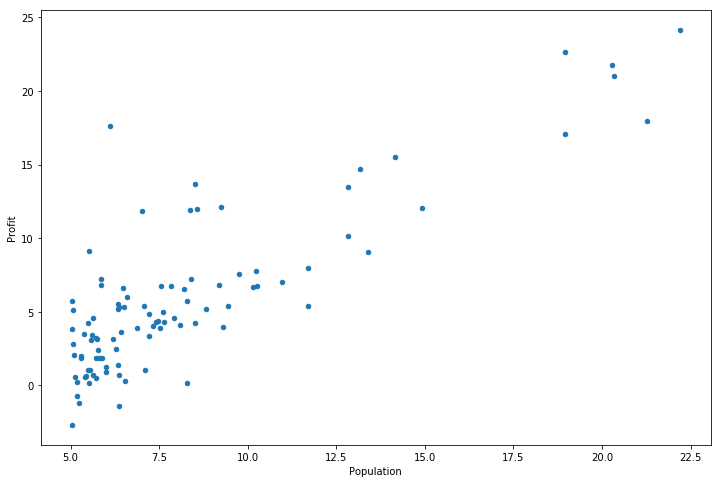

In [7]:
df_raw.plot(kind = 'scatter', x = 'Population', y = 'Profit', figsize = (12,8))

$\large J( \theta _{0} ,\ \theta _{1}) =\frac{1}{2m}\sum\limits ^{m}_{i=1}\left( h_{\theta }\left( x^{( i)}\right) -y^{( i)}\right)^{2}$

In [0]:
 def compute_cost(X, y, theta):
  predictions = X * theta.T
  error = predictions - y
  sum_square_error = np.sum(np.square(error))
  m = len(y)
  cost = sum_square_error / ( 2 * m )
  return cost

In [10]:
# Append a bias column to the beginning
# of the DataFrame. This will be used when computing
# the hypothesis.
if 'Bias' not in df_raw:
  # Insert new column at index 0, with name Bias and
  # a value of all ones.
  df_raw.insert(0, 'Bias', 1)
  
df_raw.head()

,Bias,Population,Profit
0,1,6.1101,17.5920
1,1,5.5277,9.1302
2,1,8.5186,13.6620
3,1,7.0032,11.8540
4,1,5.8598,6.8233


In [11]:
# Set X (independent/training variable) 
# and y (dependent/target variable)
cols = df_raw.shape[1]

# Get the first two columns of our DataFrame and assign to X.
X = df_raw.iloc[:,0:cols-1]

# Get the last column of our DataFrame and assign to y.
y = df_raw.iloc[:,cols-1:cols]

# Convert from DataFrames to numpy matrices for easier
# calculations.
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([0,0]))

X.shape, theta.shape, y.shape

((97, 2), (1, 2), (97, 1))

In [12]:
print(f'Cost with a theta0 of {theta[0,0]} and theta1 of {theta[0,1]} is {compute_cost(X, y, theta)}')

Cost with a theta0 of 0 and theta1 of 0 is 32.072733877455676


*repeat until convergence {* 

​	$temp 0:= \theta_{0}-\alpha\frac{1}{m}\sum\limits ^{m}_{i=1}\left( h_{\theta }\left( x^{(i)}\right) -y^{( i)}\right)$

​	$temp1 := \theta_{1}-\alpha\frac{1}{m}\sum\limits ^{m}_{i=1}\left( h_{\theta }\left( x^{(i)}\right) -y^{( i)}\right)\cdot x^{(i)}$

​	$\theta_{0} := temp0$

​	$\theta_{1} := temp1$

*}* 

In [0]:
def gradient_descent(X, y, theta, alpha):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    m = len(y)
    cost = []
    interations = 0
    converged = False
    
    while not converged:
      predictions = X * theta.T
      error = predictions - y
      x = X[:,1]
      
      #temp = theta - ( alpha * ( np.sum(np.multiply(error, x)) / m ) )
      
      temp[0,0] = theta[0,0] - ((alpha / m) * np.sum(np.multiply(error, x)))
      temp[0,1] = theta[0,1] - ((alpha / m) * np.sum(np.multiply(error, x)))
      
      #for j in range(parameters):
      #    term = np.multiply(error, X[:,j])
      #    temp[0,j] = theta[0,j] - ((alpha / m) * np.sum(term))

      theta = temp
      
      # Compute the cost
      cost.append(compute_cost(X, y, theta))
      
      c = len(cost) - 1

      # Check for convergence
      if(c > 0 and cost[c] == cost[c - 1]):
        converged = True
        iterations = c + 1
        
    return theta, cost, iterations

In [103]:
optimal_theta, cost, iterations = gradient_descent(X, y, theta, .01)

print(f'Found the optimal theta values of {optimal_theta} with a cost of {cost[len(cost) - 1]} in {iterations} iterations.')

Found the optimal theta values of [[0.72941179 0.72941179]] with a cost of 6.424480529615911 in 16 iterations.


Text(0.5, 1.0, 'Predicted Profit vs. Population Size')

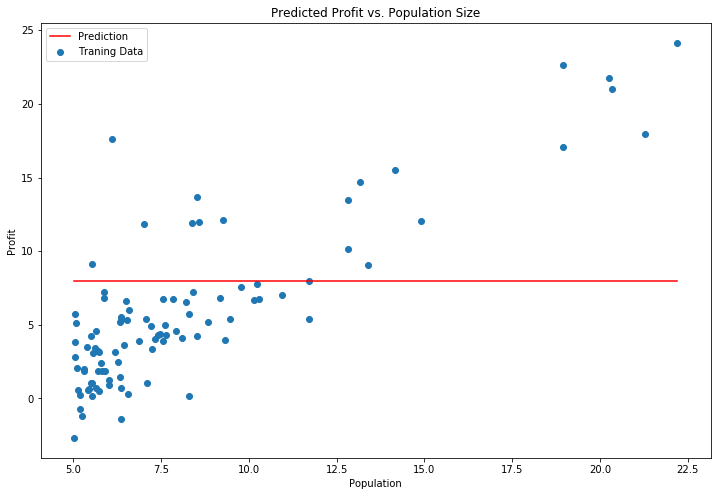

In [101]:
# Return evenly spaced numbers over a specified interval of 100.
x = np.linspace(df_raw.Population.min(), df_raw.Population.max(), 100)
f = optimal_theta[0, 0] + (optimal_theta[0, 1] * x)

fig, ax = plt.subplots(figsize = (12,8))

ax.plot(x, f, 'r', label='Prediction')
ax.scatter(df_raw.Population, df_raw.Profit, label='Traning Data')
ax.legend(loc = 2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')

Text(0.5, 1.0, 'Error vs. Training Epoch')

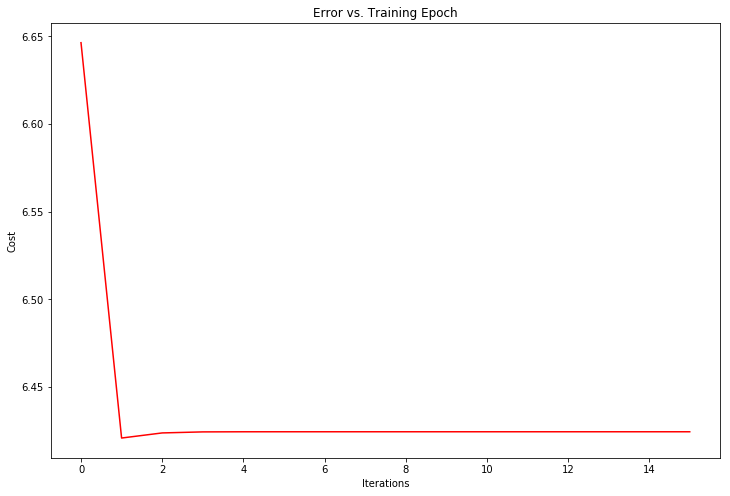

In [88]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iterations), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')